In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU is available.')
else:
    print('No GPU is available.')
# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


GPU is available.


In [2]:
import gym_super_mario_bros
from gym.spaces import Box
from gym import Wrapper
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
import cv2
import numpy as np
import subprocess as sp

""" 
 Contains Monitor class to preorpcess and record
"""
class Monitor:
    def __init__(self, width, height, saved_path):

        self.command = ["ffmpeg", "-y", "-f", "rawvideo", "-vcodec", "rawvideo", "-s", "{}X{}".format(width, height),
                        "-pix_fmt", "rgb24", "-r", "60", "-i", "-", "-an", "-vcodec", "mpeg4", saved_path]
        try:
            self.pipe = sp.Popen(self.command, stdin=sp.PIPE, stderr=sp.PIPE)
        except FileNotFoundError:
            pass

    def record(self, image_array):
        try:
            self.pipe = sp.Popen(self.command, stdin=sp.PIPE, stderr=sp.PIPE)
        except FileNotFoundError as e:
            print(f"Error creating Monitor: {e}")



def process_frame(frame):
    if frame is not None:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84))[None, :, :] / 255.
        return frame
    else:
        return np.zeros((1, 84, 84))


# class CustomReward(Wrapper):
#     def __init__(self, env=None, monitor=None):
#         super(CustomReward, self).__init__(env)
#         self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
#         self.curr_score = 0
#         if monitor:
#             self.monitor = monitor
#         else:
#             self.monitor = None

#     def step(self, action):
#         state, reward, done, info = self.env.step(action)
#         if self.monitor:
#             self.monitor.record(state)
#         state = process_frame(state)
#         reward += (info["score"] - self.curr_score) / 40.
#         self.curr_score = info["score"]
#         if done:
#             if info["flag_get"]:
#                 reward += 100
#             else:
#                 reward -= 50
#         return state, reward *0.05, done, info


class CustomReward(Wrapper):
    def __init__(self, env=None, monitor=None):
        super(CustomReward, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
        self.prev_x_position = 0
        self.time_penalty = -0.01
        if monitor:
            self.monitor = monitor
        else:
            self.monitor = None

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if self.monitor:
            self.monitor.record(state)
        state = process_frame(state)
        # Calculate distance traveled (reward proportional to x-position increase)
        x_position = info["x_pos"]
        reward += (x_position - self.prev_x_position) * 0.1
        self.prev_x_position = x_position

        # Apply time penalty
        reward += self.time_penalty
        if done:
            if info["flag_get"]:
                reward += 100
            else:
                reward -= 50
        return state, reward *0.05, done, info
    
    def reset(self):
        self.prev_x_position = 0
        return process_frame(self.env.reset())

    # def reset(self):
    #     self.curr_score = 0
    #     return process_frame(self.env.reset())


class CustomSkipFrame(Wrapper):
    def __init__(self, env, skip=4):
        super(CustomSkipFrame, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(skip, 84, 84))
        self.skip = skip
        self.states = np.zeros((skip, 84, 84), dtype=np.float32)

    def step(self, action):
        total_reward = 0
        last_states = []
        for i in range(self.skip):
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if i >= self.skip /2:
                last_states.append(state)
            if done:
                self.reset()
                return self.states[None, :, :, :].astype(np.float32), total_reward, done, info
        max_state = np.max(np.concatenate(last_states,0), 0)
        self.states[:-1] = self.states[1:]
        self.states[-1] = max_state
        return self.states[None, :, :, :].astype(np.float32), total_reward, done, info


    def reset(self):
        state = self.env.reset()
        self.states = np.concatenate([state for _ in range(self.skip)], 0)
        return self.states[None, :, :, :].astype(np.float32)


def create_train_env(actions, output_path=None):
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
    if output_path:
        monitor = Monitor(256, 240, output_path)
    else:
        monitor = None

    env = JoypadSpace(env, actions)
    env = CustomReward(env, monitor)
    env = CustomSkipFrame(env)
    return env


import torch.multiprocessing as mp

class MultipleEnvironments:
    def __init__(self, action_type, num_envs, output_path=None):
        self.agent_conns, self.env_conns = zip(*[mp.Pipe() for _ in range(num_envs)])
        if action_type == "right":
            actions = RIGHT_ONLY
            print("Action Right SET")
        elif action_type == "simple":
            actions = SIMPLE_MOVEMENT
            print("Action Simple Movements SET")
        else:
            actions = COMPLEX_MOVEMENT
            print("Action Complex SET")
        self.envs = [create_train_env(actions, output_path=output_path) for _ in range(num_envs)]
        print("sself env done")
        self.num_states = self.envs[0].observation_space.shape[0]
        print("sefl state done")
        self.num_actions = len(actions)
        print("Action done SET")
            
        for index in range(num_envs):
            print("Action: Startring process")
            process = mp.Process(target=self.run, args=(index,))
            print("Action: process IniI")
            process.start()
            print("Action: process almost done")
            self.env_conns[index].close()
        print("Environments created and processes started.")

    def run(self, index):
        self.agent_conns[index].close()
        while True:
            request, action = self.env_conns[index].recv()
            print(f"Environment {index} received request: {request}")
            if request == "step":
                print(f"Environment {index} is stepping with action: {action.item()}")
                self.env_conns[index].send(self.envs[index].step(action.item()))
            elif request == "reset":
                print(f"Environment {index} is resetting")
                self.env_conns[index].send(self.envs[index].reset())
            else:
                raise NotImplementedError


PPO Model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, initializers

class PPO(tf.keras.Model):
    def __init__(self, num_inputs, num_actions):
        super(PPO, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', input_shape=num_inputs)
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.linear = tf.keras.layers.Dense(512, activation='relu')
        self.critic_linear = tf.keras.layers.Dense(1)
        self.actor_linear = tf.keras.layers.Dense(num_actions)
        # No need for _initialize_weights method if using default initializations

    def call(self, inputs):
        x = tf.nn.relu(self.conv1(inputs))
        x = tf.nn.relu(self.conv2(x))
        x = tf.nn.relu(self.conv3(x))
        x = tf.nn.relu(self.conv4(x))
        x = self.flatten(x)
        x = tf.nn.relu(self.linear(x))
        actor_output = self.actor_linear(x)
        critic_output = self.critic_linear(x)
        return actor_output, critic_output

Train processes

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [5]:
# !python -m pip install tensorflow_probability==0.12.2

In [6]:
import warnings

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
import timeit
from tensorboardX import SummaryWriter
import numpy as np
import tensorflow_probability as tfp

from collections import deque

In [8]:
# def eval(opt, global_model, num_states, num_actions):
#     tf.random.set_seed(123)
#     if opt.action_type == "right":
#         actions = RIGHT_ONLY
#     elif opt.action_type == "simple":
#         actions = SIMPLE_MOVEMENT
#     else:
#         actions = COMPLEX_MOVEMENT
#     env = create_train_env(actions=actions)
#     local_model = PPO(num_states, num_actions)
#     # local_model.evaluate()
#     state = tf.convert_to_tensor(env.reset())
#     done = True
#     curr_step = 0
#     actions = deque(maxlen=opt.max_actions)
#     while True:
#         curr_step +=1
#         if done:
#             local_model.set_weights(global_model.get_weights())
#             logits, value = local_model(state)
#             policy = tf.nn.softmax(logits, dim=1)
#             action = tf.argmax(policy).item()
#             state, reward, done, info = env.step(action)
#            # Uncomment following lines if you want to save model whenever level is completed
#             if info["flag_get"]:
#                 print("Finished")
#                 local_model.saved_model("{}/ppo_super_mario_bros_{".format(opt.saved_path,curr_step))

#             env.render()
#             actions.append(action)
#             if curr_step > opt.num_global_steps or actions.count(actions[0]) == actions.maxlen:
#                 done = True
#             if done:
#                 curr_step = 0
#                 actions.clear()
#                 state = env.reset()
#             state = tf.convert_to_tensor(state)


Running for 1000 EP

In [9]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
from argparse import Namespace
import multiprocessing as _mp
import shutil
import tensorflow as tf
import warnings
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_args():
    args = Namespace(
        action_type="COMPLEX_MOVEMENT",
        lr=0.00001,
        gamma=0.95,
        tau=1.0,
        beta=0.01,
        num_local_steps=100,
        num_processes=2,
        save_interval=250,
        # max_actions=200,
        log_path="tensorboard/a3c_super_mario_bros",
        saved_path="trained_models",
        load_from_previous_stage=False,
        num_epochs= 10,
        batch_size = 10,
        epsilon = 0.3,
        output_path = "output"
    )
    return args


In [10]:
# from tensorflow_probability import distributions as tfd

In [11]:
#  envs = create_train_env(actions=RIGHT_ONLY)
#  print(f"states : {envs.observation_space.shape}")
#  print(f"actions : {envs.action_space.n}")

In [12]:

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tensorflow.keras.callbacks import ModelCheckpoint


In [13]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
consecutive_perfect_rewards = 0
consecutive_episodes_to_stop = 10
episode_list = []
total_steps_list = []
total_rewards_list = []
mean_rewards_list = []
total_loss_list = []

def train(opt, total_ep):
    print("INITIALIZING")
    tf.random.set_seed(123)
    print("SEED SET")
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path)
    if not os.path.isdir(opt.saved_path):
        os.makedirs(opt.saved_path)

    envs = create_train_env(actions=COMPLEX_MOVEMENT)
    print("ENV DONE")
    model = PPO(num_inputs=envs.observation_space.shape, num_actions=envs.action_space.n)
    print("PPO SET")
    model.build((None,) + envs.observation_space.shape)
    print("PPO BUILD")

    optimizer = tf.keras.optimizers.Adam(learning_rate=opt.lr)
    curr_states = envs.reset()

    curr_episode = 0
    current_total_rewards = 0

    print("Done initializing")
    
    # Set up ModelCheckpoint callback
    checkpoint_path = "{}/ppo_super_mario_bros_v2_checkpoint".format(opt.saved_path)
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        save_best_only=True,  # Set to True if you only want to keep the best model
        monitor='total_rewards',  # Change 'total_rewards' to the metric you want to monitor
        mode='max',  # Adjust the mode based on the metric (e.g., 'max' for accuracy, 'min' for loss)
        verbose=1
    )
    # Initialize best_total_rewards before the training loop    
    best_total_rewards = float('-inf')
    while curr_episode < total_ep:
        curr_episode += 1
        total_steps = 0
        old_log_policies = []
        actions = []
        values = []
        states = []
        rewards = []
        dones = []


        for _ in range(opt.num_local_steps):
            total_steps +=1
            states.append(curr_states)
            logits, value = model(curr_states)
            values.append(tf.squeeze(value))
            policy = tf.nn.softmax(logits, axis=1)
            old_m = tfp.distributions.Categorical(probs=policy)
            action = old_m.sample()
            actions.append(action)
            old_log_policy = old_m.log_prob(action)
            old_log_policies.append(old_log_policy)
            
            # #!render 
            # envs.render()
            # display(plt.gcf())
            # clear_output(wait=True)

            state, reward, done, info = envs.step(action.numpy().item())
            rewards.append(reward)
            dones.append(done)
            curr_states = state
            # Update current_total_rewards after collecting rewards for the episode
        current_total_rewards = sum(rewards)
        if current_total_rewards > best_total_rewards:
            print(f"Saving model with best total_rewards: {current_total_rewards}")
            model.save("{}/ppo_super_mario_bros_v2".format(opt.saved_path), signatures=None)
            best_total_rewards = current_total_rewards
            current_total_rewards
            #!render
            # envs.render()
            # display(plt.gcf())
            # clear_output(wait=True)


        _, next_value = model(curr_states)
        next_value = tf.squeeze(next_value)
        old_log_policies = tf.concat(old_log_policies, axis=0)
        actions = tf.concat(actions, axis=0)
        values = tf.concat(values, axis=0)
        states = tf.concat(states, axis=0)

        
        gae = 0
        R = []

        # Calculate advantages and accumulate returns
        for value, reward, done in list(zip(values, rewards, dones))[::-1]:
            gae = gae * opt.gamma * opt.tau
            gae = gae + reward + opt.gamma * next_value * (1 - done) - value
            next_value = value
            R.append(gae + value)

        R = R[::-1]
        R = tf.concat(R, axis=0)
        advantages = R - values

        # PPO update loop
        for i in range(opt.num_epochs):
            indices = tf.random.shuffle(tf.range(opt.num_local_steps * opt.num_processes))
            for j in range(opt.batch_size):
                batch_indices = indices[
                    int(j * (opt.num_local_steps * opt.num_processes / opt.batch_size)): int((j + 1) * (
                            opt.num_local_steps * opt.num_processes / opt.batch_size))]

                # Gather states, actions, and old log policies using batch_indices
                batch_indices = tf.cast(batch_indices, dtype=tf.int32) #!
                batch_states = tf.gather(states, batch_indices)
                batch_actions = tf.gather(actions, batch_indices)
                batch_old_log_policies = tf.gather(old_log_policies, batch_indices)

                # Forward pass through the model
                with tf.GradientTape() as tape:
                    logits, value = model(batch_states)
                    new_policy = tf.nn.softmax(logits, axis=1)
                    new_m = tfp.distributions.Categorical(probs=new_policy)
                    new_log_policy = new_m.log_prob(batch_actions)

                    # PPO loss calculation
                    ratio = tf.exp(new_log_policy - batch_old_log_policies)
                    actor_loss = -tf.reduce_mean(tf.minimum(
                        ratio * tf.gather(advantages, batch_indices),
                        tf.clip_by_value(ratio, 1.0 - opt.epsilon, 1.0 + opt.epsilon) * tf.gather(advantages, batch_indices)
                    ))
                    R = tf.cast(R, dtype=tf.float32)
                    value = tf.cast(value, dtype=tf.float32)

                    critic_loss = tf.reduce_mean(tf.losses.mean_squared_error(R, value))
                    entropy_loss = tf.reduce_mean(new_m.entropy())
                    total_loss = actor_loss + critic_loss - opt.beta * entropy_loss

                # Optimization step
                gradients = tape.gradient(total_loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 0.5)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Calculate metrics
        episode_list.append(curr_episode)
        total_steps_list.append(total_steps)
        total_rewards_list.append(sum(rewards))
        total_loss_list.append(total_loss)

        print("Episode: {}. Total Steps: {}. Total Rewards: {}. Total Loss: {}".format(
        curr_episode,
        total_steps,
        sum(rewards),
        total_loss
    ))
    # envs.close()



if __name__ == "__main__":
    opt = get_args()
    train(opt,total_ep=1000) 

INITIALIZING
SEED SET


c:\Users\sudha\py10\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(


ENV DONE
PPO SET
PPO BUILD
Done initializing
Saving model with best total_rewards: 8.790000000000001


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 1. Total Steps: 100. Total Rewards: 8.790000000000001. Total Loss: 3.340068817138672
Episode: 2. Total Steps: 100. Total Rewards: -0.7599999999999999. Total Loss: 0.11948607861995697
Episode: 3. Total Steps: 100. Total Rewards: 3.3100000000000023. Total Loss: 2.5452444553375244
Episode: 4. Total Steps: 100. Total Rewards: -4.059999999999996. Total Loss: 1.3412781953811646
Episode: 5. Total Steps: 100. Total Rewards: 0.23000000000000403. Total Loss: 0.5591002702713013
Episode: 6. Total Steps: 100. Total Rewards: 1.8249999999999957. Total Loss: 2.900700807571411
Episode: 7. Total Steps: 100. Total Rewards: 0.010000000000002077. Total Loss: 0.8663215637207031
Episode: 8. Total Steps: 100. Total Rewards: -1.8149999999999988. Total Loss: 0.27480095624923706
Saving model with best total_rewards: 12.380000000000003


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 9. Total Steps: 100. Total Rewards: 12.380000000000003. Total Loss: 4.0899271965026855
Episode: 10. Total Steps: 100. Total Rewards: 5.730000000000002. Total Loss: 1.4747568368911743
Episode: 11. Total Steps: 100. Total Rewards: -1.1999999999999997. Total Loss: 1.1253992319107056
Episode: 12. Total Steps: 100. Total Rewards: -3.1250000000000004. Total Loss: 2.0202934741973877
Episode: 13. Total Steps: 100. Total Rewards: -0.04499999999999989. Total Loss: 0.38798171281814575
Episode: 14. Total Steps: 100. Total Rewards: -0.9800000000000001. Total Loss: 1.7358734607696533
Episode: 15. Total Steps: 100. Total Rewards: -1.86. Total Loss: 0.3035227656364441
Episode: 16. Total Steps: 100. Total Rewards: 0.06500000000000025. Total Loss: 0.16372999548912048
Episode: 17. Total Steps: 100. Total Rewards: -1.9150000000000007. Total Loss: 0.2497340440750122
Episode: 18. Total Steps: 100. Total Rewards: -0.32000000000000034. Total Loss: -0.015051556751132011
Episode: 19. Total Steps: 100. 

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 22. Total Steps: 100. Total Rewards: 19.535000000000004. Total Loss: 2.840644121170044
Saving model with best total_rewards: 29.74600000000002


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 23. Total Steps: 100. Total Rewards: 29.74600000000002. Total Loss: 14.830612182617188
Episode: 24. Total Steps: 100. Total Rewards: 27.37500000000001. Total Loss: 10.762165069580078
Episode: 25. Total Steps: 100. Total Rewards: 21.62500000000001. Total Loss: 11.407918930053711
Episode: 26. Total Steps: 100. Total Rewards: 13.885. Total Loss: 12.446348190307617
Episode: 27. Total Steps: 100. Total Rewards: 29.190999999999974. Total Loss: 14.307812690734863
Episode: 28. Total Steps: 100. Total Rewards: 7.98499999999999. Total Loss: 6.063970565795898
Episode: 29. Total Steps: 100. Total Rewards: -1.4750000000000003. Total Loss: 1.3206011056900024
Episode: 30. Total Steps: 100. Total Rewards: -1.035. Total Loss: 0.49449068307876587
Episode: 31. Total Steps: 100. Total Rewards: -2.2449999999999983. Total Loss: 0.6087355613708496
Episode: 32. Total Steps: 100. Total Rewards: -1.5849999999999986. Total Loss: 0.65447598695755
Episode: 33. Total Steps: 100. Total Rewards: -0.815000000

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 60. Total Steps: 100. Total Rewards: 30.09500000000001. Total Loss: 14.84636116027832
Episode: 61. Total Steps: 100. Total Rewards: -1.2000000000000004. Total Loss: 3.644984006881714
Episode: 62. Total Steps: 100. Total Rewards: -1.2000000000000004. Total Loss: 0.745600700378418
Episode: 63. Total Steps: 100. Total Rewards: -1.5850000000000009. Total Loss: 0.28841930627822876
Episode: 64. Total Steps: 100. Total Rewards: -1.200000000000001. Total Loss: 0.5902112722396851
Episode: 65. Total Steps: 100. Total Rewards: -1.9700000000000006. Total Loss: 0.17110121250152588
Episode: 66. Total Steps: 100. Total Rewards: -0.15500000000000003. Total Loss: -0.05570501834154129
Episode: 67. Total Steps: 100. Total Rewards: -1.5850000000000002. Total Loss: 0.04625842720270157
Episode: 68. Total Steps: 100. Total Rewards: -0.7049999999999998. Total Loss: -0.006600828841328621
Episode: 69. Total Steps: 100. Total Rewards: -1.2. Total Loss: 0.04442043974995613
Episode: 70. Total Steps: 100. 

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 97. Total Steps: 100. Total Rewards: 31.065999999999992. Total Loss: 13.547043800354004
Episode: 98. Total Steps: 100. Total Rewards: 24.320000000000036. Total Loss: 10.490730285644531
Episode: 99. Total Steps: 100. Total Rewards: 26.22000000000003. Total Loss: 17.455629348754883
Episode: 100. Total Steps: 100. Total Rewards: 30.190000000000005. Total Loss: 15.685331344604492
Episode: 101. Total Steps: 100. Total Rewards: 14.120999999999999. Total Loss: 13.916796684265137
Episode: 102. Total Steps: 100. Total Rewards: 20.836000000000006. Total Loss: 4.37644624710083
Saving model with best total_rewards: 32.92600000000002


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 103. Total Steps: 100. Total Rewards: 32.92600000000002. Total Loss: 4.334622383117676
Episode: 104. Total Steps: 100. Total Rewards: 21.130000000000038. Total Loss: 4.412187099456787
Episode: 105. Total Steps: 100. Total Rewards: 24.294999999999995. Total Loss: 10.166743278503418
Episode: 106. Total Steps: 100. Total Rewards: 19.205. Total Loss: 4.027594566345215
Episode: 107. Total Steps: 100. Total Rewards: 24.521. Total Loss: 3.0774037837982178
Episode: 108. Total Steps: 100. Total Rewards: 22.560000000000016. Total Loss: 4.751276016235352
Episode: 109. Total Steps: 100. Total Rewards: 10.735000000000012. Total Loss: 5.9246439933776855
Episode: 110. Total Steps: 100. Total Rewards: 6.090000000000001. Total Loss: 7.5683135986328125
Episode: 111. Total Steps: 100. Total Rewards: 26.795000000000034. Total Loss: 6.9082932472229
Episode: 112. Total Steps: 100. Total Rewards: 27.75650000000003. Total Loss: 4.739362716674805
Episode: 113. Total Steps: 100. Total Rewards: 26.46500

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 115. Total Steps: 100. Total Rewards: 34.13200000000003. Total Loss: 10.483033180236816
Saving model with best total_rewards: 34.660000000000004


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 116. Total Steps: 100. Total Rewards: 34.660000000000004. Total Loss: 0.609365701675415
Episode: 117. Total Steps: 100. Total Rewards: -0.37500000000000017. Total Loss: 13.472980499267578
Episode: 118. Total Steps: 100. Total Rewards: -1.2000000000000002. Total Loss: 6.934062957763672
Episode: 119. Total Steps: 100. Total Rewards: -1.2000000000000002. Total Loss: 3.8657443523406982
Episode: 120. Total Steps: 100. Total Rewards: -1.6949999999999998. Total Loss: 3.023819923400879
Episode: 121. Total Steps: 100. Total Rewards: -0.9249999999999995. Total Loss: 1.1461894512176514
Episode: 122. Total Steps: 100. Total Rewards: -0.979999999999999. Total Loss: 1.434385895729065
Episode: 123. Total Steps: 100. Total Rewards: -1.2000000000000006. Total Loss: -0.00818018801510334
Episode: 124. Total Steps: 100. Total Rewards: 7.435000000000004. Total Loss: 3.851464033126831
Episode: 125. Total Steps: 100. Total Rewards: 10.470000000000002. Total Loss: 3.1981966495513916
Episode: 126. Tot

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 127. Total Steps: 100. Total Rewards: 42.23100000000006. Total Loss: 19.389488220214844
Episode: 128. Total Steps: 100. Total Rewards: 35.69150000000002. Total Loss: 14.381404876708984
Episode: 129. Total Steps: 100. Total Rewards: 30.626000000000012. Total Loss: 7.046847343444824
Episode: 130. Total Steps: 100. Total Rewards: 26.300000000000004. Total Loss: 3.0945308208465576
Episode: 131. Total Steps: 100. Total Rewards: 41.69150000000006. Total Loss: 9.562936782836914
Episode: 132. Total Steps: 100. Total Rewards: 31.181000000000036. Total Loss: 9.848719596862793
Episode: 133. Total Steps: 100. Total Rewards: 15.134999999999993. Total Loss: 6.120346546173096
Episode: 134. Total Steps: 100. Total Rewards: -1.2000000000000006. Total Loss: 7.840091705322266
Episode: 135. Total Steps: 100. Total Rewards: -3.2350000000000003. Total Loss: 5.555517673492432
Episode: 136. Total Steps: 100. Total Rewards: 1.385000000000004. Total Loss: 1.981808066368103
Episode: 137. Total Steps: 10

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 222. Total Steps: 100. Total Rewards: 47.035000000000004. Total Loss: 2.255918025970459
Episode: 223. Total Steps: 100. Total Rewards: 40.97650000000001. Total Loss: 12.094673156738281
Episode: 224. Total Steps: 100. Total Rewards: 21.325000000000014. Total Loss: 15.262232780456543
Episode: 225. Total Steps: 100. Total Rewards: 21.679999999999986. Total Loss: 2.166823387145996
Episode: 226. Total Steps: 100. Total Rewards: 25.060999999999993. Total Loss: 15.426397323608398
Episode: 227. Total Steps: 100. Total Rewards: 12.360000000000008. Total Loss: 11.930259704589844
Episode: 228. Total Steps: 100. Total Rewards: 29.951000000000008. Total Loss: 5.14113187789917
Episode: 229. Total Steps: 100. Total Rewards: 27.481999999999978. Total Loss: 9.073389053344727
Episode: 230. Total Steps: 100. Total Rewards: 35.20999999999998. Total Loss: 6.600677490234375
Episode: 231. Total Steps: 100. Total Rewards: -1.2550000000000006. Total Loss: 9.606176376342773
Episode: 232. Total Steps: 1

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 439. Total Steps: 100. Total Rewards: 48.50600000000003. Total Loss: 12.701470375061035
Episode: 440. Total Steps: 100. Total Rewards: 33.86699999999999. Total Loss: 13.988450050354004
Episode: 441. Total Steps: 100. Total Rewards: 33.27600000000003. Total Loss: 3.2052102088928223
Episode: 442. Total Steps: 100. Total Rewards: 34.06200000000002. Total Loss: 9.083845138549805
Episode: 443. Total Steps: 100. Total Rewards: 22.615000000000023. Total Loss: 5.145033836364746
Episode: 444. Total Steps: 100. Total Rewards: 16.09600000000001. Total Loss: 6.5395989418029785
Episode: 445. Total Steps: 100. Total Rewards: 26.190000000000033. Total Loss: 1.3826630115509033
Episode: 446. Total Steps: 100. Total Rewards: 32.16050000000001. Total Loss: 4.876402378082275
Episode: 447. Total Steps: 100. Total Rewards: 37.190000000000026. Total Loss: 0.17940689623355865
Episode: 448. Total Steps: 100. Total Rewards: 32.482000000000035. Total Loss: 12.853170394897461
Episode: 449. Total Steps: 1

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 765. Total Steps: 100. Total Rewards: 48.946000000000055. Total Loss: 8.099781036376953
Episode: 766. Total Steps: 100. Total Rewards: 35.05800000000002. Total Loss: 18.650617599487305
Episode: 767. Total Steps: 100. Total Rewards: 31.25000000000003. Total Loss: 6.176722526550293
Episode: 768. Total Steps: 100. Total Rewards: 21.860500000000012. Total Loss: 6.878843307495117
Episode: 769. Total Steps: 100. Total Rewards: 34.376000000000026. Total Loss: 5.357491493225098
Episode: 770. Total Steps: 100. Total Rewards: 29.26000000000001. Total Loss: 4.567211627960205
Episode: 771. Total Steps: 100. Total Rewards: 11.55999999999999. Total Loss: 3.937021017074585
Episode: 772. Total Steps: 100. Total Rewards: -1.2000000000000006. Total Loss: 4.324585437774658
Episode: 773. Total Steps: 100. Total Rewards: -1.2000000000000004. Total Loss: 0.7887452244758606
Episode: 774. Total Steps: 100. Total Rewards: -1.2550000000000006. Total Loss: 0.12060921639204025
Episode: 775. Total Steps: 

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros_v2\assets


Episode: 851. Total Steps: 100. Total Rewards: 60.23500000000005. Total Loss: 17.58004379272461
Episode: 852. Total Steps: 100. Total Rewards: 35.121000000000016. Total Loss: 26.094585418701172
Episode: 853. Total Steps: 100. Total Rewards: 42.30500000000006. Total Loss: 1.3446646928787231
Episode: 854. Total Steps: 100. Total Rewards: 31.515000000000015. Total Loss: 6.818317413330078
Episode: 855. Total Steps: 100. Total Rewards: 33.17499999999997. Total Loss: 6.336103916168213
Episode: 856. Total Steps: 100. Total Rewards: 25.77500000000001. Total Loss: 18.81035614013672
Episode: 857. Total Steps: 100. Total Rewards: 24.581000000000028. Total Loss: 8.101564407348633
Episode: 858. Total Steps: 100. Total Rewards: 35.54000000000001. Total Loss: 2.0957329273223877
Episode: 859. Total Steps: 100. Total Rewards: 33.3455. Total Loss: 14.440522193908691
Episode: 860. Total Steps: 100. Total Rewards: 32.69800000000003. Total Loss: 6.185563087463379
Episode: 861. Total Steps: 100. Total Rewar

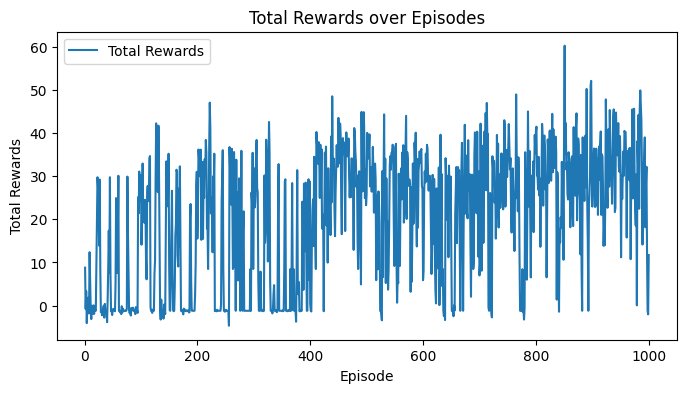

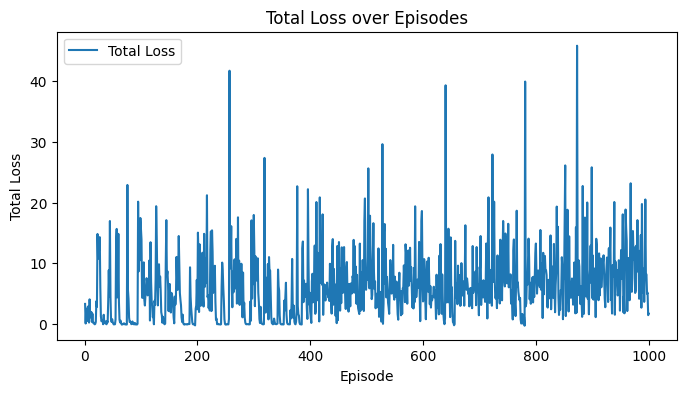

In [14]:
import matplotlib.pyplot as plt

# Plot Total Rewards
plt.figure(figsize=(8, 4))
plt.plot(episode_list, total_rewards_list, label='Total Rewards')
plt.title('Total Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()



# Plot Total Loss
plt.figure(figsize=(8, 4))
plt.plot(episode_list, total_loss_list, label='Total Loss')
plt.title('Total Loss over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Loss')
plt.legend()
plt.show()


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from argparse import Namespace

# Import your environment creation function and PPO model definition here
# Assuming COMPLEX_MOVEMENT, create_train_env, and PPO are imported

def test_saved_model(opt):
    # Load the saved model
    loaded_model = tf.keras.models.load_model("{}/ppo_super_mario_bros_v2".format(opt.saved_path))

    # Create the environment
    env = create_train_env(actions=COMPLEX_MOVEMENT)
    state = env.reset()

    done = False
    total_reward = 0

    while not done:
        # Forward pass through the loaded model to get the action
        logits, _ = loaded_model(state)
        action = tf.argmax(tf.nn.softmax(logits, axis=1)).numpy().item()

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        # Accumulate total reward
        total_reward += reward

        # Render the environment (optional)
        env.render()
        display(plt.gcf())
        clear_output(wait=True)

    env.close()

    print(f"Total reward with the saved model: {total_reward}")
    return total_reward

if __name__ == "__main__":
    opt = get_args()

    # Test the saved model
    total_reward = test_saved_model(opt)


NameError: name 'create_train_env' is not defined